In [3]:
#from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
#from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display
import networkx as nx


import flylib as flb
#from thllib import flylib as flb
import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from flylib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display
import pandas as pd
import networkx as nx

In [4]:
%matplotlib inline

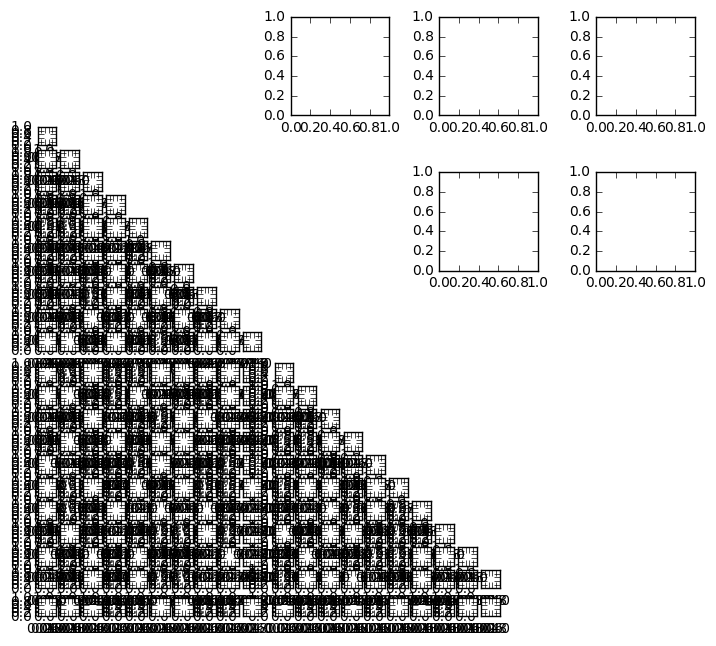

In [5]:
layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)

In [6]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]

In [7]:
fly_nums = range(1389,1402)#,1545)
multi_fly_df = util.construct_multi_fly_df(fly_nums)

Making dataframe for fly number 1389
Making dataframe for fly number 1390
Making dataframe for fly number 1391
Making dataframe for fly number 1392
Making dataframe for fly number 1393
Making dataframe for fly number 1394
Making dataframe for fly number 1395
Making dataframe for fly number 1396
Making dataframe for fly number 1397
Making dataframe for fly number 1398
Making dataframe for fly number 1399
Making dataframe for fly number 1400
Making dataframe for fly number 1401


In [8]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

flydict = {}
for fly in flylist:
    flydict[fly.flynum] = fly
    
stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')]

In [9]:
sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',

                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',

                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}

In [10]:
print(multi_fly_df.columns.values)
print(np.unique(multi_fly_df['stimulus']))

idx = (multi_fly_df['stimulus']=='cl_blocks, g_x=-1, g_y=0, b_x=-8, b_y=0, ch=True')& \
        ((multi_fly_df['amp_diff']>0.1)&(multi_fly_df['amp_diff']<0.104))


['t' 'stimulus' 'amp_diff' 'left_amp' 'right_amp' 'fly_num' 'pr_left'
 'tpd_left' 'nm_left' 'iii1_left' 'iii3_left' 'i2_left' 'hg2_left'
 'hg3_left' 'hg1_left' 'i1_left' 'bkg_left' 'b1_left' 'b2_left' 'b3_left'
 'iii24_left' 'hg4_left' 'pr_right' 'tpd_right' 'nm_right' 'iii1_right'
 'iii3_right' 'i2_right' 'hg2_right' 'hg3_right' 'hg1_right' 'i1_right'
 'bkg_right' 'b1_right' 'b2_right' 'b3_right' 'iii24_right' 'hg4_right']
['cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0'
 'ol_blocks, g_x=-12, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'
 'ol_blocks, g_x=12, g_y=0 b_x=0, 

In [11]:
def plot_sector_kine(flylist,
                sector,ax,
                pathspecs,
                mode = 'hist',
                contours = False,
                rng = (25,95)):
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',

                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',

                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}

    block_key = sector_map[sector]

    if mode == 'hist':
        group_hist = get_group_hist(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'])
        sector_mask = np.array([group_hist>0.5]*4)
        ps = pathspecs[sector]
        fc = ps.mplkwargs()['facecolor']
        sector_img = (sector_mask*fc[:,None,None]).T
        ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))
    if mode == 'kde':
        group_hists = get_kde_estimates_kine(flylist,rng = rng,
                                             block_keys = [block_key],
                                 condition_keys = ['condition=test'],
                                 bandwidth = 5,
                                 nbins = 100)
        print np.shape(group_hists)
        group_hists = np.product(group_hists,axis = 0)
        if contours:
            #sector_mask = np.array(group_hists>0.001*4)
            #pad the mask to deal with corners and edges
            sector_mask = group_hists
            padr = np.zeros(np.shape(sector_mask)[1])
            sector_mask = np.vstack((padr,sector_mask,padr))
            padc = np.zeros((np.shape(sector_mask)[0],1)) 
            sector_mask = np.hstack((padc,sector_mask,padc))
            #get the contour
            from skimage import measure
            level = np.percentile(group_hists,90)
            contours = measure.find_contours(sector_mask,level)
            if len(contours) > 1:
                print('more than one contour found')
                contour = contours[np.argmax([len(c) for c in contours])].T
            else:
                contour = contours[0].T
            #put back in data coords
            cy = (contour[0]-1)/(np.shape(sector_mask)[0]-1)
            cx = (contour[1]-1)/(np.shape(sector_mask)[1]-1)
            
            cy =cy*(rng[1]-rng[0]) + rng[0]
            cx =cx*(rng[1]-rng[0]) + rng[0]
            
            if (cy[0] != cy[-1]) | (cx[0] != cx[-1]):
                #close the contours
                cy = np.hstack([cy,cy[0]])
                cx = np.hstack([cx,cx[0]])
            ps = pathspecs[sector]
            kwargs = ps.mplkwargs()
            ax.fill(cx,cy,clip_on = False,**kwargs)
        else:
            sector_mask = np.array([group_hists>0.001]*4)
            ps = pathspecs[sector]
            fc = ps.mplkwargs()['facecolor']
            sector_img = np.transpose(sector_mask*fc[:,None,None],(1,2,0))[::-1,:,:]
            ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))

In [12]:
def plot_sector(flylist,
                xkey,ykey,
                sector,ax,
                pathspecs,
                mode = 'hist',
                contours = False):
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',
                  
                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',
                  
                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}
    
    block_key = sector_map[sector]
    if mode == 'hist':
        group_hist = get_group_hist(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'])
        sector_mask = np.array([group_hist>0.5]*4)
        ps = pathspecs[sector]
        fc = ps.mplkwargs()['facecolor']
        sector_img = (sector_mask*fc[:,None,None]).T
        ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))
    if mode == 'kde':
        group_hists = get_kde_estimates(flylist,
                                 xkey,
                                 ykey,
                                 block_keys = [block_key],
                                 condition_keys = ['condition=test'],
                                 bandwidth = 0.1,
                                 nbins = 100)
        group_hists = np.product(group_hists,axis = 0)
        if contours:
            #sector_mask = np.array(group_hists>0.001*4)
            #pad the mask to deal with corners and edges
            sector_mask = group_hists
            padr = np.zeros(np.shape(sector_mask)[1])
            sector_mask = np.vstack((padr,sector_mask,padr))
            padc = np.zeros((np.shape(sector_mask)[0],1)) 
            sector_mask = np.hstack((padc,sector_mask,padc))
            #get the contour
            from skimage import measure
            contours = measure.find_contours(sector_mask,30.5)
            if len(contours) > 1:
                print('more than one contour found for:')
                print('%s %s - %s %s'%(xkey + ykey))
                contour = contours[np.argmax([len(c) for c in contours])].T
            else:
                contour = contours[0].T
            #put back in data coords
            cy = (contour[0]-1)/(np.shape(sector_mask)[0]-1)
            cx = (contour[1]-1)/(np.shape(sector_mask)[1]-1)
            if (cy[0] != cy[-1]) | (cx[0] != cx[-1]):
                #close the contours
                cy = np.hstack([cy,cy[0]])
                cx = np.hstack([cx,cx[0]])
            ps = pathspecs[sector]
            #fc = ps.mplkwargs()['facecolor']
            #ec = ps.mplkwargs()['edgecolor']
            kwargs = ps.mplkwargs()
            ax.fill(cx,cy,clip_on = False,**kwargs)
        else:
            sector_mask = np.array([group_hists>0.001]*4)
            ps = pathspecs[sector]
            fc = ps.mplkwargs()['facecolor']
            sector_img = np.transpose(sector_mask*fc[:,None,None],(1,2,0))[::-1,:,:]
            ax.imshow(sector_img,interpolation = 'None',extent = (0,1,0,1))


In [26]:
def get_kde_estimates(flies,xkey,ykey,
                      condition_keys = [],
                      block_keys = [],
                      nbins = 50,bandwidth = 0.05):
    from sklearn.neighbors.kde import KernelDensity
    pdfs = []
    for fly in flies:
        try:
            dmask = fly.data_mask
            c_masks = []
            b_masks = []

            for ckey in condition_keys:
                c_masks.append(np.array(fly.experimental_condition) == ckey)
            for bkey in block_keys:
                b_masks.append(np.array(fly.experimental_block) == bkey)
            if len(c_masks)>0:
                if len(b_masks)>0:
                    dmask = dmask & np.any(b_masks,axis = 0) & np.any(c_masks,axis = 0)
                else:
                    dmask = dmask & np.any(c_masks,axis = 0)
            else:
                if len(b_masks)>0:
                    dmask = dmask & np.any(b_masks,axis = 0)

            x = fly.non_neg_signals[xkey][dmask]
            y = fly.non_neg_signals[ykey][dmask]
            X = np.array([x,y])
            xedges = np.linspace(0,1,nbins)
            yedges = np.linspace(0,1,nbins)
            gridx,gridy = np.meshgrid(xedges,yedges)
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.T)
            smps = kde.score_samples(np.vstack((gridx.ravel(),gridy.ravel())).T)
            pdfs.append((np.exp(smps.reshape(np.shape(gridx)))))
        except ValueError:
            pass
    return pdfs

In [17]:
def get_kde_estimates_kine(flies,rng = (25,95),
                      condition_keys = [],
                      block_keys = [],
                      nbins = 50,bandwidth = 10):
    from sklearn.neighbors.kde import KernelDensity
    #from thllib import util
    from flylib import util
    pdfs = []
    for fly in flies:
        #try:
        dmask = fly.data_mask
        c_masks = []
        b_masks = []

        for ckey in condition_keys:
            c_masks.append(np.array(fly.experimental_condition) == ckey)
        for bkey in block_keys:
            b_masks.append(np.array(fly.experimental_block) == bkey)
        if len(c_masks)>0:
            if len(b_masks)>0:
                dmask = dmask & np.any(b_masks,axis = 0) & np.any(c_masks,axis = 0)
            else:
                dmask = dmask & np.any(c_masks,axis = 0)
        else:
            if len(b_masks)>0:
                dmask = dmask & np.any(b_masks,axis = 0)

        x = util.fill_nan(np.rad2deg(np.array(fly.left_amp)[dmask]))
        y = util.fill_nan(np.rad2deg(np.array(fly.right_amp)[dmask]))
        X = np.array([x,y])
        X[np.isnan(X)] = 0
        X = np.squeeze(X)
        xedges = np.linspace(rng[0],rng[1],nbins)
        yedges = np.linspace(rng[0],rng[1],nbins)
        gridx,gridy = np.meshgrid(xedges,yedges)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.T)
        smps = kde.score_samples(np.vstack((gridx.ravel(),gridy.ravel())).T)
        pdfs.append((np.exp(smps.reshape(np.shape(gridx)))))
        #except ValueError:
        #    pass
    return pdfs

In [24]:


c_l = layout.pathspecs['lb-nu'].mplkwargs()['edgecolor']
c_r = layout.pathspecs['rb-nu'].mplkwargs()['edgecolor']


(13, 100, 100)
(13, 100, 100)
(13, 100, 100)


(None,
 None,
 <matplotlib.text.Text at 0x7f08578dbf10>)

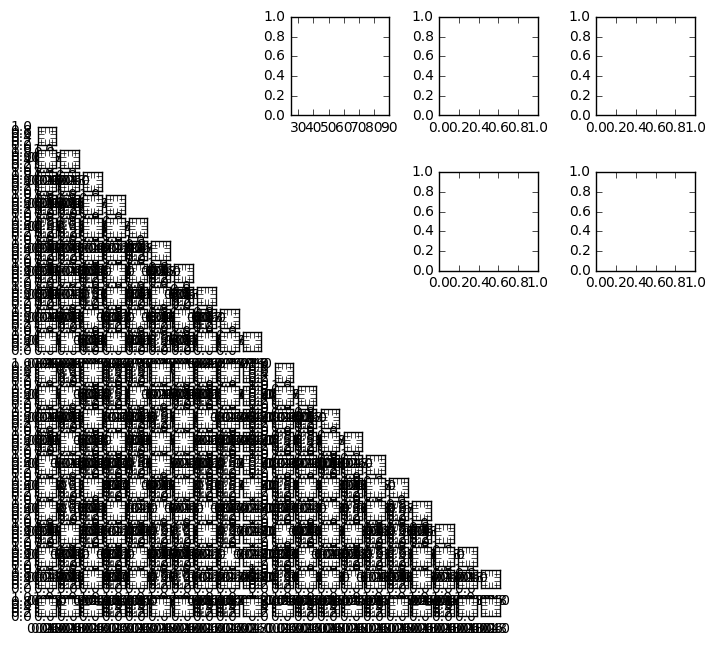

In [27]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)


ax1 = layout.axes['kinematics']
plot_sector_kine(flylist,'nb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'rb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'lb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax1.set_xbound(25,90),ax.set_ybound(25,90),ax.set_xlabel('left amp',color = c_l),ax.set_ylabel('right amp',color = c_r)

ax2 = layout.axes['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax2.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right b3',color = c_r)

ax3 = layout.axes['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax3.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left iii3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax4.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax5.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left hg1',color = c_l),ax.set_ylabel('right i1',color = c_r)

KeyError: 'kinefly'

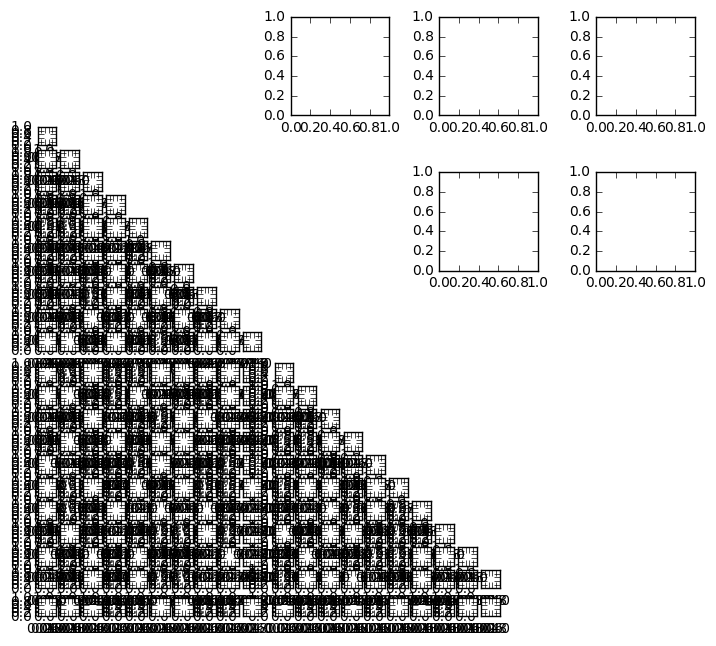

In [30]:
##########################
#  Example traces        #
##########################

layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)


fly = flylist[-9]
snum =4
idx = fly.block_data['common','idx','cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
tms = np.array(fly.time)[idx]
tms -= tms[0]

c_l = layout.pathspecs['lb-nu'].mplkwargs()['edgecolor']
c_r = layout.pathspecs['rb-nu'].mplkwargs()['edgecolor']

yrng = slice(100,400)
xrng = slice(50,450)
layout.axes['kinefly'].imshow(fly.kine_cam_1[idx[125]].T[:,::-1][yrng,xrng],cmap = plt.cm.gray)
layout.axes['left_hinge'].imshow(fly.ca_cam_left[idx[125]][:,::-1][:,50:]**1.2,vmin = 0,vmax = 450,cmap = plt.cm.gray)
layout.axes['right_hinge'].imshow(fly.ca_cam_right[idx[125]][:,::-1][:,:150]**1.2,vmin = 0,vmax = 450,cmap = plt.cm.gray)

layout.axes['wing_kine'].plot(tms,np.rad2deg(np.array(fly.left_amp)[idx]),color = c_l)
layout.axes['wing_kine'].plot(tms,np.rad2deg(np.array(fly.right_amp)[idx]),color = c_r)
layout.axes['wing_kine'].set_ybound(25,65)
layout.axes['wing_kine'].set_yticks([25,35,45,55,65])
layout.axes['wing_kine'].set_ylabel('Stroke amp\n(deg)')

layout.axes['i1'].plot(tms,fly.non_neg_signals['left','i1'][idx],color = c_l)
layout.axes['i1'].plot(tms,fly.non_neg_signals['right','i1'][idx],color = c_r)
layout.axes['i1'].set_ybound(0,1)
layout.axes['i1'].set_yticks([0,1])
layout.axes['i1'].set_ylabel('i1 GCaMP\n(AU)')

layout.axes['iii3'].plot(tms,fly.non_neg_signals['left','iii3'][idx],color = c_l)
layout.axes['iii3'].plot(tms,fly.non_neg_signals['right','iii3'][idx],color = c_r)
layout.axes['iii3'].set_ybound(0,1)
layout.axes['iii3'].set_yticks([0,1])
layout.axes['iii3'].set_ylabel('iii3 GCaMP\n(AU)')

layout.axes['b3'].plot(tms,fly.non_neg_signals['left','b3'][idx],color = c_l)
layout.axes['b3'].plot(tms,fly.non_neg_signals['right','b3'][idx],color = c_r)
layout.axes['b3'].set_ybound(0,1)
layout.axes['b3'].set_yticks([0,1])
layout.axes['b3'].set_ylabel('b3 GCaMP\n(AU)')
layout.axes['b3'].set_xlabel('time (s)')

layout.axes['l_vs_r'].plot(np.rad2deg(np.array(fly.left_amp)[idx]),
                             np.rad2deg(np.array(fly.right_amp)[idx]),color = 'k')
layout.axes['l_vs_r'].set_xbound(25,65)
layout.axes['l_vs_r'].set_ybound(25,65)

layout.axes['l_vs_r'].set_ylabel('right amp',color = c_r)
layout.axes['l_vs_r'].set_xlabel('left amp',color = c_l)

layout.axes['muscle_vs_muscle'].plot(fly.non_neg_signals['left','iii3'][idx],
                                       fly.non_neg_signals['right','b3'][idx],color = 'k')
layout.axes['muscle_vs_muscle'].set_xbound(0,1)
layout.axes['muscle_vs_muscle'].set_ybound(0,1)
layout.axes['muscle_vs_muscle'].set_ylabel('right b3',color = c_r)
layout.axes['muscle_vs_muscle'].set_xlabel('left iii3',color = c_l)


In [32]:
def make_scatter_plots(fly,ax_group):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    import figurefirst as fifi
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)

        # keymap = {}
        #l = [keymap.update({key:(key_to_key(key[0]),key_to_key(key[1]))}) for key in layout.axes.keys()]
        #keymap.pop('flynum')
        for key1,g in ax_group.items():
            for key2,ax in g.items():
                try:
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
                    dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
                    ax.scatter(dta1,dta2,
                               marker = '.',
                               s = 0.5,
                               color = 'k',
                               alpha = 0.5,
                               edgecolors = 'none',
                               rasterized = True)
                    ax.set_xbound(0,1)
                    ax.set_ybound(0,1)
                    fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))

In [38]:
def key_to_key(inkey):
    """map the input key from the cov_mtrx_triang_layout.svg into a set of keys 
    (a tuple of tuples) that can be used to construct signals from the fly data"""
    try:
        k1 = {'R':'right','L':'left'}[inkey[0]]
    except KeyError:
        if inkey[0] == 'w':
            return ('common','wb_freq')
        else:
            return
    k2 = inkey[1:]
    return (k1,k2)

(13, 100, 100)
(13, 100, 100)
(13, 100, 100)


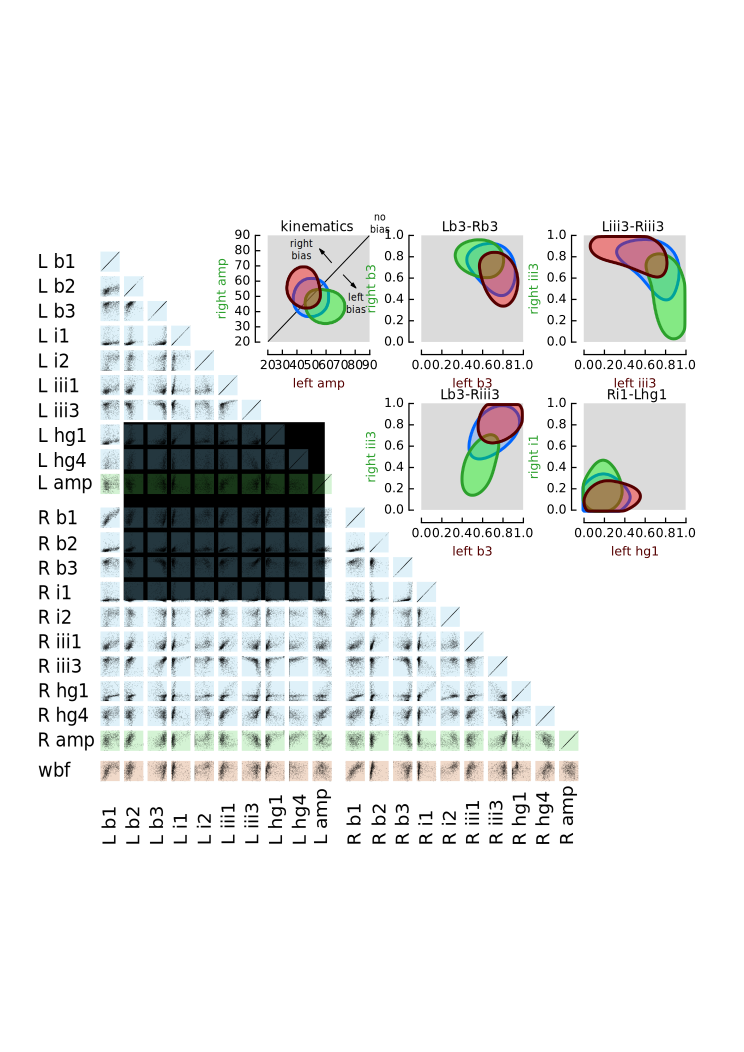

In [41]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

#layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)
layout = fifi.FigureLayout('layouts/scatter_contour_layout.svg',make_mplfigures = True)




make_scatter_plots(flylist[6],layout.axes_groups['none']['scatter_mtrx'])

ax1 = layout.axes_groups['none']['expanded_inset']['kinematics']
plot_sector_kine(flylist,'nb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'rb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'lb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax1.set_xbound(25,90),ax1.set_ybound(25,90),ax1.set_xlabel('left amp',color = c_l),ax1.set_ylabel('right amp',color = c_r)

ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
ax2.set_xbound(0,1),ax2.set_ybound(0,1),ax2.set_xlabel('left b3',color = c_l),ax2.set_ylabel('right b3',color = c_r)

ax3 = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
ax3.set_xbound(0,1),ax3.set_ybound(0,1),ax3.set_xlabel('left iii3',color = c_l),ax3.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
ax4.set_xbound(0,1),ax4.set_ybound(0,1),ax4.set_xlabel('left b3',color = c_l),ax4.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
ax5.set_xbound(0,1),ax5.set_ybound(0,1),ax5.set_xlabel('left hg1',color = c_l),ax5.set_ylabel('right i1',color = c_r)

fifi.mpl_functions.set_spines(layout)
layout.save('prototype_contours.svg')
plt.close('all')
display(SVG('prototype_contours.svg'))

In [ ]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

#layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)
layout = fifi.FigureLayout('layouts/scatter_contour_layout.svg',make_mplfigures = True)




make_scatter_plots(flylist[6],layout.axes_groups['none']['scatter_mtrx'])

ax1 = layout.axes_groups['none']['expanded_inset']['kinematics']
plot_sector_kine(flylist,'nb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'rb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'lb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax1.set_xbound(25,90),ax1.set_ybound(25,90),ax1.set_xlabel('left amp',color = c_l),ax1.set_ylabel('right amp',color = c_r)

ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
ax2.set_xbound(0,1),ax2.set_ybound(0,1),ax2.set_xlabel('left b3',color = c_l),ax2.set_ylabel('right b3',color = c_r)

ax3 = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
ax3.set_xbound(0,1),ax3.set_ybound(0,1),ax3.set_xlabel('left iii3',color = c_l),ax3.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
ax4.set_xbound(0,1),ax4.set_ybound(0,1),ax4.set_xlabel('left b3',color = c_l),ax4.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
ax5.set_xbound(0,1),ax5.set_ybound(0,1),ax5.set_xlabel('left hg1',color = c_l),ax5.set_ylabel('right i1',color = c_r)

fifi.mpl_functions.set_spines(layout)
layout.save('prototype_contours_2.svg')
plt.close('all')
display(SVG('prototype_contours_2.svg'))

In [ ]:
def mini_scatter_begin(key1, key2):
    dkeys = (key_to_key(key1),key_to_key(key2))
                    dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
                    dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
                    ax.scatter(dta1,dta2,
                               marker = '.',
                               s = 0.5,
                               color = 'k',
                               alpha = 0.5,
                               edgecolors = 'none',
                               rasterized = True)
                    ax.set_xbound(0,1)
                    ax.set_ybound(0,1)
                    fifi.mpl_functions.kill_spines(ax)
                    
                    fly.experimental_block

In [133]:
def mini_scatter_kine(ax, key1, key2, sector, color_choice):
    dkeys = (key_to_key(key1),key_to_key(key2))
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',
                  
                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',
                  
                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}
    
    block_key = sector_map[sector]
    b_masks =[]
    dmask = fly.data_mask
    b_masks.append(np.array(fly.experimental_block) == block_key)
    if len(b_masks)>0:
            dmask = dmask & np.any(b_masks,axis = 0)

    x = util.fill_nan(np.rad2deg(np.array(fly.left_amp)[dmask]))
    y = util.fill_nan(np.rad2deg(np.array(fly.right_amp)[dmask]))
        
    x1 = fly.non_neg_signals[key1][dmask]
    print x1
    y1 = fly.non_neg_signals[key2][dmask]
    
    #dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
    #dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
    #ax.scatter(dta1,dta2,
    ax1.scatter(x,y,
                    marker = '.',
                    s = 0.5,
                    color = color_choice, #color = 'k',
                    alpha = 0.8,
                    edgecolors = 'none',
                    rasterized = True)
    ax1.set_xbound(25,95)
    ax1.set_ybound(25, 95)
    fifi.mpl_functions.kill_spines(ax1)

def mini_scatter(axis, key1, key2, sector, color_choice):
    ax = axis
    dkeys = (key_to_key(key1),key_to_key(key2))
    sector_map = {'rb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0',
                  'nb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0',
                  'lb-tu':'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0',
                  
                  'rb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0',
                  'nb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0',
                  'lb-nu':'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0',
                  
                  'rb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0',
                  'nb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0',
                  'lb-td':'cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'}
    
    block_key = sector_map[sector]
    b_masks =[]
    dmask = fly.data_mask
    b_masks.append(np.array(fly.experimental_block) == block_key)
    if len(b_masks)>0:
            dmask = dmask & np.any(b_masks,axis = 0)

    x = util.fill_nan(np.rad2deg(np.array(fly.left_amp)[dmask]))
    y = util.fill_nan(np.rad2deg(np.array(fly.right_amp)[dmask]))
        
    x1 = fly.non_neg_signals[key1][dmask]
    print x1
    y1 = fly.non_neg_signals[key2][dmask]
    
    #dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
    #dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
    #ax.scatter(dta1,dta2,
    ax.scatter(x1,y1,
                    marker = '.',
                    s = 0.5,
                    color = color_choice, #color = 'k',
                    alpha = 0.8,
                    edgecolors = 'none',
                    rasterized = True)
    ax.set_xbound(0,1)
    ax.set_ybound(0,1)
    fifi.mpl_functions.kill_spines(ax)
                    

In [ ]:
#mini_scatter(ax1, ('left', 'b3'), ('right', 'b3'), 'nb-nu')

In [ ]:
layout = fifi.FigureLayout('layouts/scatter_contour_layout.svg',make_mplfigures = True)


make_scatter_plots(flylist[6],layout.axes_groups['none']['scatter_mtrx'])


ax1 = layout.axes_groups['none']['expanded_inset']['kinematics']
mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'nb-nu', 'blue')
#plot_sector_kine(flylist,'rb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'rb-nu', 'green')
#plot_sector_kine(flylist,'lb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'lb-nu', 'red')

ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
#ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
#plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'nb-nu', 'blue')
#plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'rb-nu', 'green')
#plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'lb-nu', 'red')
#ax2.set_xbound(0,1),ax2.set_ybound(0,1),ax2.set_xlabel('left b3',color = c_l),ax2.set_ylabel('right b3',color = c_r)


ax3 = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
#plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'nb-nu', 'blue')
#plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'rb-nu', 'green')
#plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'lb-nu', 'red')
#ax3.set_xbound(0,1),ax3.set_ybound(0,1),ax3.set_xlabel('left iii3',color = c_l),ax3.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
#plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'nb-nu', 'blue')
#plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'rb-nu', 'green')
#plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'lb-nu', 'red')
#ax4.set_xbound(0,1),ax4.set_ybound(0,1),ax4.set_xlabel('left b3',color = c_l),ax4.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
#plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'nb-nu', 'blue')
#plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'rb-nu', 'green')
#plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'lb-nu', 'red')
#ax5.set_xbound(0,1),ax5.set_ybound(0,1),ax5.set_xlabel('left hg1',color = c_l),ax5.set_ylabel('right i1',color = c_r)

#fifi.mpl_functions.set_spines(layout)



ax1 = layout.axes_groups['none']['expanded_inset']['kinematics']
plot_sector_kine(flylist,'nb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
#mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'nb-nu', 'blue')
plot_sector_kine(flylist,'rb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
#mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'rb-nu', 'green')
plot_sector_kine(flylist,'lb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
#mini_scatter_kine(ax1, ('left', 'b3'), ('right', 'b3'), 'lb-nu', 'red')
ax1.set_xbound(25,90),ax1.set_ybound(25,90),ax1.set_xlabel('left amp',color = c_l),ax1.set_ylabel('right amp',color = c_r)


ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'nb-nu', 'blue')
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'rb-nu', 'green')
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax2, ('left', 'b3'), ('right', 'b3'), 'lb-nu', 'red')
ax2.set_xbound(0,1),ax2.set_ybound(0,1),ax2.set_xlabel('left b3',color = c_l),ax2.set_ylabel('right b3',color = c_r)

ax3 = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'nb-nu', 'blue')
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'rb-nu', 'green')
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax3, ('left', 'iii3'), ('right', 'iii3'), 'lb-nu', 'red')
ax3.set_xbound(0,1),ax3.set_ybound(0,1),ax3.set_xlabel('left iii3',color = c_l),ax3.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'nb-nu', 'blue')
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'rb-nu', 'green')
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax4, ('left', 'b3'), ('right', 'iii3'), 'lb-nu', 'red')
ax4.set_xbound(0,1),ax4.set_ybound(0,1),ax4.set_xlabel('left b3',color = c_l),ax4.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'nb-nu', 'blue')
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'rb-nu', 'green')
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
#mini_scatter(ax5, ('left', 'hg1'), ('right', 'i1'), 'lb-nu', 'red')
ax5.set_xbound(0,1),ax5.set_ybound(0,1),ax5.set_xlabel('left hg1',color = c_l),ax5.set_ylabel('right i1',color = c_r)

#fifi.mpl_functions.set_spines(layout)

#fifi.mpl_functions.set_spines(layout)

#layout.apply_mpl_methods()   #not sure if theses were commented or not
fifi.mpl_functions.set_spines(layout)


layout.save('prototype_contours_4.svg')
plt.close('all')
display(SVG('prototype_contours_4.svg'))


[ 0.37670929  0.37155381  0.37155381 ...,  0.88565182  0.88565182
  0.91448277]
[ 0.54038872  0.54038872  0.57278155 ...,  0.61365671  0.61365671
  0.59141499]
[ 0.7989303   0.7989303   0.84438572 ...,  0.94212859  0.94212859
  0.93038332]
[ 0.37670929  0.37155381  0.37155381 ...,  0.88565182  0.88565182
  0.91448277]
[ 0.54038872  0.54038872  0.57278155 ...,  0.61365671  0.61365671
  0.59141499]
[ 0.7989303   0.7989303   0.84438572 ...,  0.94212859  0.94212859
  0.93038332]
[ 0.93454689  0.91531355  0.91531355 ...,  0.73982136  0.73982136
  0.76114998]
[ 0.92425285  0.92425285  0.92741685 ...,  0.82204921  0.82204921  0.811214  ]
[ 0.90347402  0.90347402  0.93295423 ...,  0.0443136   0.0443136   0.0327337 ]
[ 0.37670929  0.37155381  0.37155381 ...,  0.88565182  0.88565182
  0.91448277]
[ 0.54038872  0.54038872  0.57278155 ...,  0.61365671  0.61365671
  0.59141499]
[ 0.7989303   0.7989303   0.84438572 ...,  0.94212859  0.94212859
  0.93038332]
[ 0.24321086  0.23364612  0.23364612 ..., 

In [129]:
#import svglib
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

drawing = svg2rlg("prototype_contours_4.svg")
renderPDF.drawToFile(drawing, "prototype_contours_4.pdf")

ImportError: No module named svglib.svglib

In [125]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

drawing = svg2rlg("prototype_contours_3.svg")
renderPDF.drawToFile(drawing, "prototype_contours_3.pdf")

ImportError: No module named svglib.svglib

In [ ]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

#layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)
layout = fifi.FigureLayout('layouts/scatter_contour_layout.svg',make_mplfigures = True)




make_scatter_plots(flylist[6],layout.axes_groups['none']['scatter_mtrx'])

ax1 = layout.axes_groups['none']['expanded_inset']['kinematics']
plot_sector_kine(flylist,'nb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'rb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'lb-nu',ax1,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax1.set_xbound(25,90),ax1.set_ybound(25,90),ax1.set_xlabel('left amp',color = c_l),ax1.set_ylabel('right amp',color = c_r)

ax2 = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax2,layout.pathspecs,mode = 'kde',contours = True)
ax2.set_xbound(0,1),ax2.set_ybound(0,1),ax2.set_xlabel('left b3',color = c_l),ax2.set_ylabel('right b3',color = c_r)

ax3 = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax3,layout.pathspecs,mode = 'kde',contours = True)
ax3.set_xbound(0,1),ax3.set_ybound(0,1),ax3.set_xlabel('left iii3',color = c_l),ax3.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax4,layout.pathspecs,mode = 'kde',contours = True)
ax4.set_xbound(0,1),ax4.set_ybound(0,1),ax4.set_xlabel('left b3',color = c_l),ax4.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax5,layout.pathspecs,mode = 'kde',contours = True)
ax5.set_xbound(0,1),ax5.set_ybound(0,1),ax5.set_xlabel('left hg1',color = c_l),ax5.set_ylabel('right i1',color = c_r)

fifi.mpl_functions.set_spines(layout)
layout.save('prototype_contours_2.svg')
plt.close('all')
display(SVG('prototype_contours_2.svg'))

(13, 100, 100)


KeyError: 'nb-nu'

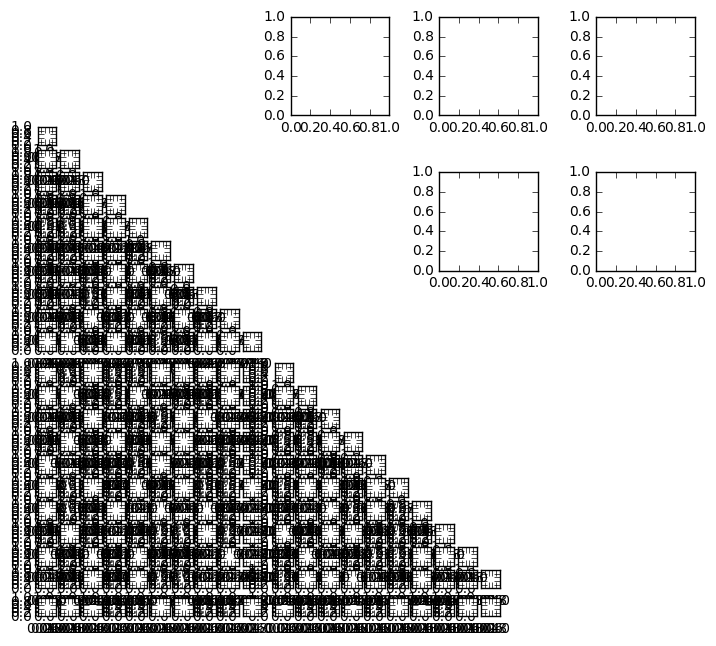

In [18]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)


ax1 = layout.axes['kinematics']
plot_sector_kine(flylist,'nb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'rb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
plot_sector_kine(flylist,'lb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax1.set_xbound(25,90),ax.set_ybound(25,90),ax.set_xlabel('left amp',color = c_l),ax.set_ylabel('right amp',color = c_r)

ax2 = layout.axes['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax2.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right b3',color = c_r)

ax3 = layout.axes['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax3.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left iii3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax4 = layout.axes['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax4.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax5 = layout.axes['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax5.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left hg1',color = c_l),ax.set_ylabel('right i1',color = c_r)

In [ ]:
dkeys = (key_to_key(key1),key_to_key(key2))
                    dta1 = fly.non_neg_signals[dkeys[0]][dmask][::50]
                    dta2 = fly.non_neg_signals[dkeys[1]][dmask][::50]
                    ax.scatter(dta1,dta2,
                               marker = '.',
                               s = 0.5,
                               color = 'k',
                               alpha = 0.5,
                               edgecolors = 'none',
                               rasterized = True)
                    ax.set_xbound(0,1)
                    ax.set_ybound(0,1)
                    fifi.mpl_functions.kill_spines(ax)

In [2]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)


ax = layout.axes['kinematics']
lpf.plot_sector_kine(flylist,'nb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'rb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'lb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax.set_xbound(25,90),ax.set_ybound(25,90),ax.set_xlabel('left amp',color = c_l),ax.set_ylabel('right amp',color = c_r)

ax = layout.axes['Lb3-Rb3']
plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right b3',color = c_r)

ax = layout.axes['Liii3-Riii3']
plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left iii3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes['Lb3-Riii3']
plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes['Ri1-Lhg1']
plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left hg1',color = c_l),ax.set_ylabel('right i1',color = c_r)

NameError: name 'fifi' is not defined

(13, 100, 100)


KeyError: 'nb-nu'

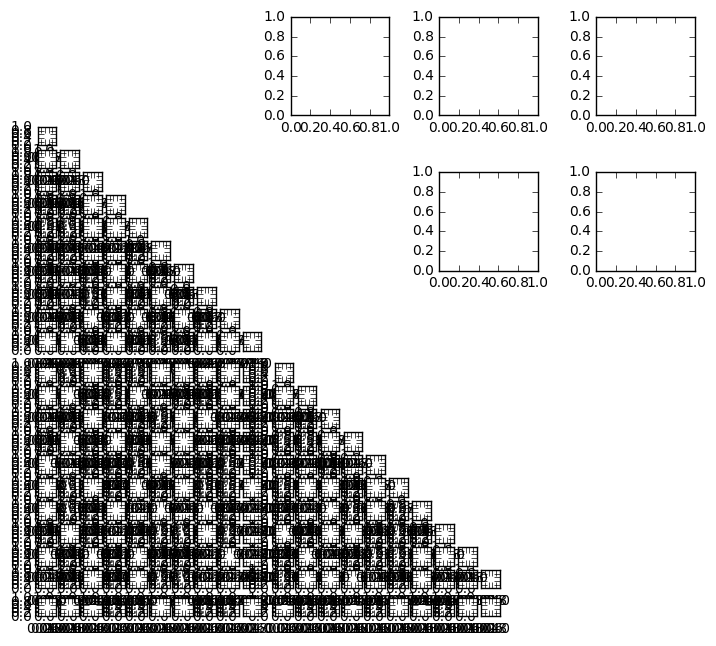

In [30]:
#lpf.make_scatter_plots(flylist[6])#,layout.axes_groups)

layout = fifi.FigureLayout('layouts/scatter_anc_contour_layout.svg',make_mplfigures = True)

ax = layout.axes['kinematics']
lpf.plot_sector_kine(flylist,'nb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'rb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'lb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax.set_xbound(25,90),ax.set_ybound(25,90),ax.set_xlabel('left amp',color = c_l),ax.set_ylabel('right amp',color = c_r)

ax = layout.axes['Lb3-Rb3']
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right b3',color = c_r)

ax = layout.axes['Liii3-Riii3']
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left iii3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes['Lb3-Riii3']
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes['Ri1-Lhg1']
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left hg1',color = c_l),ax.set_ylabel('right i1',color = c_r)

In [10]:
example_group  = layout.axes_groups['none']['examples']
fly = flylist[-9]
snum =4
idx = fly.block_data['common','idx','cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
tms = np.array(fly.time)[idx]
tms -= tms[0]

c_l = layout.pathspecs['lb-nu'].mplkwargs()['edgecolor']
c_r = layout.pathspecs['rb-nu'].mplkwargs()['edgecolor']

yrng = slice(100,400)
xrng = slice(50,450)
example_group['kinefly'].imshow(fly.kine_cam_1[idx[125]].T[:,::-1][yrng,xrng],cmap = plt.cm.gray)
example_group['left_hinge'].imshow(fly.ca_cam_left[idx[125]][:,::-1][:,50:]**1.2,vmin = 0,vmax = 450,cmap = plt.cm.gray)
example_group['right_hinge'].imshow(fly.ca_cam_right[idx[125]][:,::-1][:,:150]**1.2,vmin = 0,vmax = 450,cmap = plt.cm.gray)

example_group['wing_kine'].plot(tms,np.rad2deg(np.array(fly.left_amp)[idx]),color = c_l)
example_group['wing_kine'].plot(tms,np.rad2deg(np.array(fly.right_amp)[idx]),color = c_r)
example_group['wing_kine'].set_ybound(25,65)
example_group['wing_kine'].set_yticks([25,35,45,55,65])
example_group['wing_kine'].set_ylabel('Stroke amp\n(deg)')

example_group['i1'].plot(tms,fly.non_neg_signals['left','i1'][idx],color = c_l)
example_group['i1'].plot(tms,fly.non_neg_signals['right','i1'][idx],color = c_r)
example_group['i1'].set_ybound(0,1)
example_group['i1'].set_yticks([0,1])
example_group['i1'].set_ylabel('i1 GCaMP\n(AU)')

example_group['iii3'].plot(tms,fly.non_neg_signals['left','iii3'][idx],color = c_l)
example_group['iii3'].plot(tms,fly.non_neg_signals['right','iii3'][idx],color = c_r)
example_group['iii3'].set_ybound(0,1)
example_group['iii3'].set_yticks([0,1])
example_group['iii3'].set_ylabel('iii3 GCaMP\n(AU)')

example_group['b3'].plot(tms,fly.non_neg_signals['left','b3'][idx],color = c_l)
example_group['b3'].plot(tms,fly.non_neg_signals['right','b3'][idx],color = c_r)
example_group['b3'].set_ybound(0,1)
example_group['b3'].set_yticks([0,1])
example_group['b3'].set_ylabel('b3 GCaMP\n(AU)')
example_group['b3'].set_xlabel('time (s)')

example_group['l_vs_r'].plot(np.rad2deg(np.array(fly.left_amp)[idx]),
                             np.rad2deg(np.array(fly.right_amp)[idx]),color = 'k')
example_group['l_vs_r'].set_xbound(25,65)
example_group['l_vs_r'].set_ybound(25,65)

example_group['l_vs_r'].set_ylabel('right amp',color = c_r)
example_group['l_vs_r'].set_xlabel('left amp',color = c_l)

example_group['muscle_vs_muscle'].plot(fly.non_neg_signals['left','iii3'][idx],
                                       fly.non_neg_signals['right','b3'][idx],color = 'k')
example_group['muscle_vs_muscle'].set_xbound(0,1)
example_group['muscle_vs_muscle'].set_ybound(0,1)
example_group['muscle_vs_muscle'].set_ylabel('right b3',color = c_r)
example_group['muscle_vs_muscle'].set_xlabel('left iii3',color = c_l)


##########################
#  Scatter Plots         #
##########################

lpf.make_scatter_plots(flylist[6],layout.axes_groups['none']['scatter_mtrx'])

ax = layout.axes_groups['none']['expanded_inset']['kinematics']
lpf.plot_sector_kine(flylist,'nb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'rb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
lpf.plot_sector_kine(flylist,'lb-nu',ax,layout.pathspecs,rng = (25,95),mode = 'kde',contours = True)
ax.set_xbound(25,90),ax.set_ybound(25,90),ax.set_xlabel('left amp',color = c_l),ax.set_ylabel('right amp',color = c_r)

ax = layout.axes_groups['none']['expanded_inset']['Lb3-Rb3']
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','b3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right b3',color = c_r)

ax = layout.axes_groups['none']['expanded_inset']['Liii3-Riii3']
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','iii3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left iii3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes_groups['none']['expanded_inset']['Lb3-Riii3']
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','b3'),('right','iii3'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left b3',color = c_l),ax.set_ylabel('right iii3',color = c_r)

ax = layout.axes_groups['none']['expanded_inset']['Ri1-Lhg1']
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'nb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'rb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
lpf.plot_sector(flylist,('left','hg1'),('right','i1'),'lb-nu',ax,layout.pathspecs,mode = 'kde',contours = True)
ax.set_xbound(0,1),ax.set_ybound(0,1),ax.set_xlabel('left hg1',color = c_l),ax.set_ylabel('right i1',color = c_r)


KeyError: 'examples'

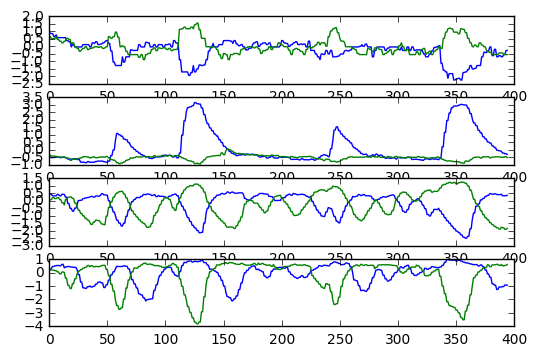

In [82]:
fly = flylist[-9]
snum =4
idx = fly.block_data['common','idx','cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
plt.subplot(4,1,1)
plt.plot(fly.normed_signals['left','amp'][idx])
plt.plot(fly.normed_signals['right','amp'][idx])
plt.subplot(4,1,2)
plt.plot(fly.normed_signals['left','i1'][idx])
plt.plot(fly.normed_signals['right','i1'][idx])
plt.subplot(4,1,3)
plt.plot(fly.normed_signals['left','iii3'][idx])
plt.plot(fly.normed_signals['right','iii3'][idx])
plt.subplot(4,1,4)
plt.plot(fly.normed_signals['left','b3'][idx])
plt.plot(fly.normed_signals['right','b3'][idx])

In [83]:
reload(lpf)

<module 'local_project_functions' from 'local_project_functions.pyc'>

In [84]:
TAU_ON_F = 0.01595905
TAU_OFF_F = 0.23594343
times = np.arange(0,90/0.02)*0.02
fast_kernel = lpf.make_single_kernel(times,TAU_ON_F,TAU_OFF_F)



In [85]:
(1-(0.08*2))/2

0.42

In [102]:
TAU_ON_S = 0.0155905
TAU_OFF_S = 0.23594343
times = np.arange(0,90/0.02)*0.02
slow_kernel = lpf.make_single_kernel(times,TAU_ON_S,TAU_OFF_S)

state_table= [[1,1],
              [0,1],
              [1,0],
              [0,0]]

tmtrx_coup = [[0.12,    0.38,    0.38,     0.12],
              [0.08,    0.76,    0.08,     0.08],
              [0.08,    0.08,    0.76,     0.08],
              [0.12,    0.38,    0.38,     0.12]]

tmtrx_coup_1 = [[0.12,    0.38,    0.38,     0.12],
              [0.08,    0.76,    0.08,     0.08],
              [0.08,    0.08,    0.76,     0.08],
              [0.12,    0.38,    0.38,     0.12]]

tmtrx_coup_2 = [[0.02,    0.08,    0.18,     0.72],
              [0.04,    0.08,    0.76,     0.12],
              [0.12,    0.76,    0.08,     0.04],
              [0.72,    0.18,    0.08,     0.02]]


# tmtrx_coup = [[0.76,    0.08,    0.08,     0.08],
#               [0.42,    0.08,    0.08,     0.42],
#               [0.42,    0.08,    0.08,     0.42],
#               [0.08,    0.08,    0.08,     0.76]]

tmtrx_coup = np.array(tmtrx_coup).T
tmtrx_coup_1 = np.array(tmtrx_coup_1).T
tmtrx_coup_2 = np.array(tmtrx_coup_2).T
print(np.sum(tmtrx_coup,axis = 0))
print(np.sum(tmtrx_coup_1,axis = 0))
print(np.sum(tmtrx_coup_2,axis = 0))

# tmtrx_ind = [[0.76,    0.08,    0.08,     0.08],
#              [0.08,    0.76,    0.08,     0.08],
#              [0.08,    0.08,    0.76,     0.08],
#              [0.32,    0.32,    0.32,     0.04]]

tmtrx_ind = [[0.70,    0.14,    0.14,     0.02],
             [0.30,    0.66,    0.02,     0.02],
             [0.30,    0.02,    0.66,     0.02],
             [0.97,    0.01,    0.01,     0.01]]

tmtrx_ind_1 = [[0.70,    0.14,    0.14,     0.02],
             [0.30,    0.66,    0.02,     0.02],
             [0.30,    0.02,    0.66,     0.02],
             [0.97,    0.01,    0.01,     0.01]]

tmtrx_ind_2 = [[0.4,    0.2,    0.2,     0.2],
             [0.5,    0.4,    0.08,     0.02],
             [0.6,    0.2,    0.18,     0.02],
             [0.8,    0.17,    0.02,     0.01]]

tmtrx_ind_3 = [[0.01,    0.01,    0.01,    0.97],
             [0.02,    0.66,    0.02,     0.30],
             [0.02,    0.02,    0.66,     0.30],
             [0.02,    0.14,    0.14,     0.70]]

tmtrx_ind_4 = [[0.02,    0.02,    0.02,     0.01],
             [0.14,    0.66,    0.02,     0.01],
             [0.14,    0.02,    0.66,     0.01],
             [0.70,    0.30,    0.30,     0.97]]



tmtrx_ind = np.array(tmtrx_ind).T
print(np.sum(tmtrx_ind,axis = 0))

tmtrx_ind_1 = np.array(tmtrx_ind_1).T
print(np.sum(tmtrx_ind_1,axis = 0))

tmtrx_ind_2 = np.array(tmtrx_ind_2).T
print(np.sum(tmtrx_ind_2,axis = 0))

tmtrx_ind_3 = np.array(tmtrx_ind_3).T
print(np.sum(tmtrx_ind_3,axis = 0))

#tmtrx_ind_4 = np.array(tmtrx_ind_4).T
#print(np.sum(tmtrx_ind_4,axis = 0))

state_table = np.array(state_table)

## simulate a coupled network
state_list_coup = [[0,1]]
state_list_coup_1 = [[0,1]]
state_list_coup_2 = [[0,1]]

for i in range(len(times)):
    state_list_coup.append(lpf.next_state(state_list_coup[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_coup).T)
state_list_coup = np.array(state_list_coup)


state_list_coup_1 = [[0,1]]
for i in range(len(times)):
    state_list_coup_1.append(lpf.next_state(state_list_coup_1[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_coup_1).T)
state_list_coup_1 = np.array(state_list_coup_1)


state_list_coup_2 = [[0,1]]
for i in range(len(times)):
    state_list_coup_2.append(lpf.next_state(state_list_coup_2[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_coup_2).T)
state_list_coup_2 = np.array(state_list_coup_2)


## simulate an independent network
state_list_ind = [[0,1]]
state_list_ind_1 = [[0,1]]
state_list_ind_2 = [[0,1]]
state_list_ind_3 = [[0,1]]
state_list_ind_4 = [[0,1]]


for i in range(len(times)):
    state_list_ind.append(lpf.next_state(state_list_ind[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_ind).T)
state_list_ind = np.array(state_list_ind)


for i in range(len(times)):
    state_list_ind_1.append(lpf.next_state(state_list_ind_1[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_ind_1).T)
state_list_ind_1 = np.array(state_list_ind_1)


for i in range(len(times)):
    state_list_ind_2.append(lpf.next_state(state_list_ind_2[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_ind_2).T)
state_list_ind_2 = np.array(state_list_ind_2)



for i in range(len(times)):
    state_list_ind_3.append(lpf.next_state(state_list_ind_3[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_ind_3).T)
state_list_ind_3 = np.array(state_list_ind_3)


#for i in range(len(times)):
#    state_list_ind_4.append(lpf.next_state(state_list_ind_4[-1],
#                                     state_table=state_table,
#                                     tmtrx = tmtrx_ind_4).T)
#state_list_ind_4 = np.array(state_list_ind_4)


## break out the signals
cell_A_ind = np.array([state_list_ind[:,0]])
cell_B_ind = np.array([state_list_ind[:,1]])
cell_A_coup = np.array([state_list_coup[:,0]])
cell_B_coup = np.array([state_list_coup[:,1]])


cell_A_ind_1 = np.array([state_list_ind_1[:,0]])
cell_B_ind_1 = np.array([state_list_ind_1[:,1]])

cell_A_ind_2 = np.array([state_list_ind_2[:,0]])
cell_B_ind_2 = np.array([state_list_ind_2[:,1]])

cell_A_ind_3 = np.array([state_list_ind_3[:,0]])
cell_B_ind_3 = np.array([state_list_ind_3[:,1]])

#cell_A_ind_4 = np.array([state_list_ind_4[:,0]])
#cell_B_ind_4 = np.array([state_list_ind_4[:,1]])

cell_A_coup_1 = np.array([state_list_coup_1[:,0]])
cell_B_coup_1 = np.array([state_list_coup_1[:,1]])

cell_A_coup_2 = np.array([state_list_coup_2[:,0]])
cell_B_coup_2 = np.array([state_list_coup_2[:,1]])



cell_A_ind_F = scipy.signal.convolve(np.squeeze(cell_A_ind),slow_kernel)
cell_B_ind_F = scipy.signal.convolve(np.squeeze(cell_B_ind),slow_kernel)
cell_A_coup_F = scipy.signal.convolve(np.squeeze(cell_A_coup),slow_kernel)
cell_B_coup_F =scipy.signal.convolve(np.squeeze(cell_B_coup),slow_kernel)



cell_A_ind_F_1 = scipy.signal.convolve(np.squeeze(cell_A_ind_1),slow_kernel)
cell_B_ind_F_1 = scipy.signal.convolve(np.squeeze(cell_B_ind_1),slow_kernel)
cell_A_coup_F_1 = scipy.signal.convolve(np.squeeze(cell_A_coup_1),slow_kernel)
cell_B_coup_F_1 =scipy.signal.convolve(np.squeeze(cell_B_coup_1),slow_kernel)


cell_A_ind_F_2 = scipy.signal.convolve(np.squeeze(cell_A_ind_2),slow_kernel)
cell_B_ind_F_2 = scipy.signal.convolve(np.squeeze(cell_B_ind_2),slow_kernel)
cell_A_coup_F_2 = scipy.signal.convolve(np.squeeze(cell_A_coup_2),slow_kernel)
cell_B_coup_F_2 =scipy.signal.convolve(np.squeeze(cell_B_coup_2),slow_kernel)

cell_A_ind_F_3 = scipy.signal.convolve(np.squeeze(cell_A_ind_3),slow_kernel)
cell_B_ind_F_3 = scipy.signal.convolve(np.squeeze(cell_B_ind_3),slow_kernel)

#cell_A_ind_F_4 = scipy.signal.convolve(np.squeeze(cell_A_ind_4),slow_kernel)
#cell_B_ind_F_4 = scipy.signal.convolve(np.squeeze(cell_B_ind_4),slow_kernel)

[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]


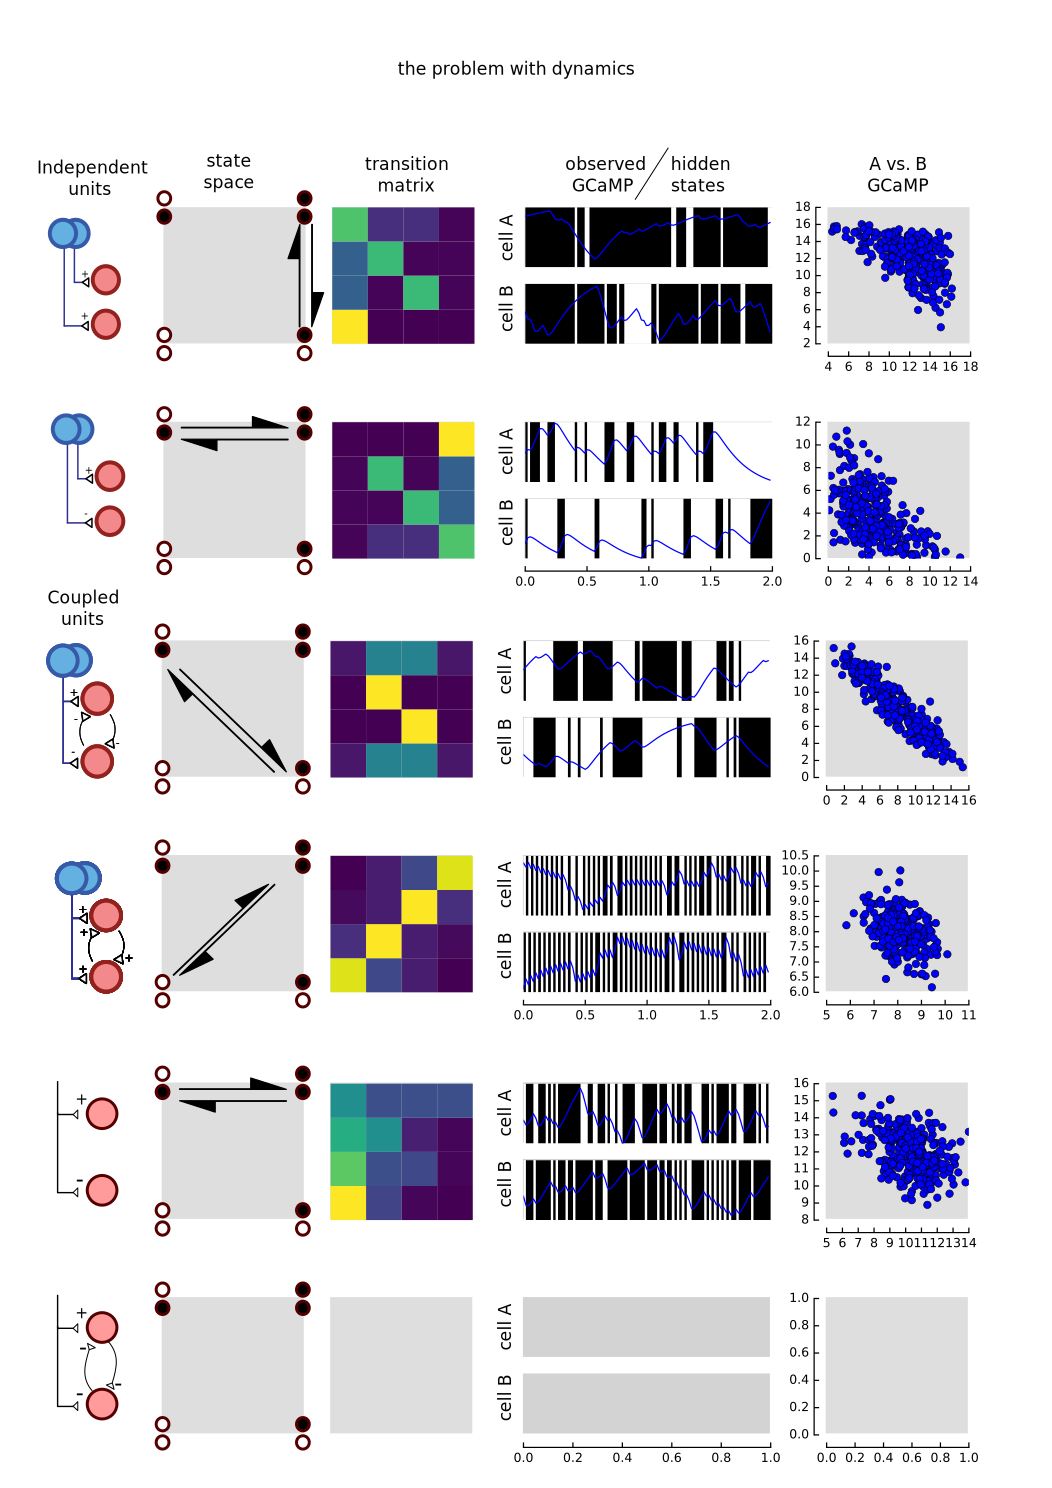

In [104]:
layout = fifi.FigureLayout('prototype_state_model_layout_6_mode_mods_1.svg',make_mplfigures = True)

layout.axes['ind_transition_1'].pcolor(tmtrx_ind_1[:,::-1].T,cmap = plt.cm.viridis)
layout.axes['ind_transition_2'].pcolor(tmtrx_ind_3[:,::-1].T,cmap = plt.cm.viridis)
layout.axes['coup_transition_1'].pcolor(tmtrx_coup_1[:,::-1].T,cmap = plt.cm.viridis)
layout.axes['coup_transition_2'].pcolor(tmtrx_coup_2[:,::-1].T,cmap = plt.cm.viridis)
layout.axes['ind_transition_3'].pcolor(tmtrx_ind_2[:,::-1].T,cmap = plt.cm.viridis)
#layout.axes['coup_transition_4'].pcolor(tmtrx_coup[:,::-1].T,cmap = plt.cm.viridis)

layout.axes['ind_cell_A_1'].imshow(cell_A_ind[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)
layout.axes['ind_cell_B_1'].imshow(cell_B_ind[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)

layout.axes['coup_cell_A_1'].imshow(cell_A_coup[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)
layout.axes['coup_cell_B_1'].imshow(cell_B_coup[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)

layout.axes['ind_cell_A_2'].imshow(cell_A_ind_3[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)
layout.axes['ind_cell_B_2'].imshow(cell_B_ind_3[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)

layout.axes['ind_cell_A_3'].imshow(cell_A_ind_2[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)
layout.axes['ind_cell_B_3'].imshow(cell_B_ind_2[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)


layout.axes['coup_cell_A_2'].imshow(cell_A_coup_2[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)
layout.axes['coup_cell_B_2'].imshow(cell_B_coup_2[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)


layout.axes['ind_cell_A_1'].set_zorder(-10)
layout.axes['ind_cell_B_1'].set_zorder(-10)

layout.axes['coup_cell_A_1'].set_zorder(-10)
layout.axes['coup_cell_B_1'].set_zorder(-10)

layout.axes['ind_cell_A_2'].set_zorder(-10)
layout.axes['ind_cell_B_2'].set_zorder(-10)

layout.axes['coup_cell_A_2'].set_zorder(-10)
layout.axes['coup_cell_B_2'].set_zorder(-10)


layout.axes['ind_cell_A_3'].set_zorder(-10)
layout.axes['ind_cell_B_3'].set_zorder(-10)



layout.axes['ind_cell_A_ts_1'].plot(times[1500:1600]-times[1500],cell_A_ind_F_1[1500:1600])
layout.axes['ind_cell_B_ts_1'].plot(times[1500:1600]-times[1500],cell_B_ind_F_1[1500:1600])

layout.axes['coup_cell_A_ts_1'].plot(times[1500:1600]-times[1500],cell_A_coup_F_1[1500:1600])
layout.axes['coup_cell_B_ts_1'].plot(times[1500:1600]-times[1500],cell_B_coup_F_1[1500:1600])


layout.axes['ind_cell_A_ts_2'].plot(times[1500:1600]-times[1500],cell_A_ind_F_3[1500:1600])
layout.axes['ind_cell_B_ts_2'].plot(times[1500:1600]-times[1500],cell_B_ind_F_3[1500:1600])

layout.axes['coup_cell_A_ts_2'].plot(times[1500:1600]-times[1500],cell_A_coup_F_2[1500:1600])
layout.axes['coup_cell_B_ts_2'].plot(times[1500:1600]-times[1500],cell_B_coup_F_2[1500:1600])


layout.axes['ind_cell_A_ts_3'].plot(times[1500:1600]-times[1500],cell_A_ind_F_2[1500:1600])
layout.axes['ind_cell_B_ts_3'].plot(times[1500:1600]-times[1500],cell_B_ind_F_2[1500:1600])



layout.axes['ind_cell_A_ts_1'].patch.set_facecolor('None')
layout.axes['ind_cell_B_ts_1'].patch.set_facecolor('None')

layout.axes['coup_cell_A_ts_1'].patch.set_facecolor('None')
layout.axes['coup_cell_B_ts_1'].patch.set_facecolor('None')

layout.axes['ind_cell_A_ts_2'].patch.set_facecolor('None')
layout.axes['ind_cell_B_ts_2'].patch.set_facecolor('None')

layout.axes['coup_cell_A_ts_2'].patch.set_facecolor('None')
layout.axes['coup_cell_B_ts_2'].patch.set_facecolor('None')

layout.axes['ind_cell_A_ts_3'].patch.set_facecolor('None')
layout.axes['ind_cell_B_ts_3'].patch.set_facecolor('None')



layout.axes['ind_GCaMP_state_1'].plot(cell_A_ind_F[1000:-5000:10],cell_B_ind_F[1000:-5000:10],'o',alpha = 0.2)
layout.axes['coup_GCaMP_state_1'].plot(cell_A_coup_F[1000:-5000:10],cell_B_coup_F[1000:-5000:10],'o',alpha = 0.2)

layout.axes['ind_GCaMP_state_2'].plot(cell_A_ind_F_3[1000:-5000:10],cell_B_ind_F_3[1000:-5000:10],'o',alpha = 0.2)
layout.axes['coup_GCaMP_state_2'].plot(cell_A_coup_F_2[1000:-5000:10],cell_B_coup_F_2[1000:-5000:10],'o',alpha = 0.2)

layout.axes['ind_GCaMP_state_3'].plot(cell_A_ind_F_2[1000:-5000:10],cell_B_ind_F_2[1000:-5000:10],'o',alpha = 0.2)


arrow_params = dict(shape = 'right',width = 0.01,length_includes_head = True,facecolor = 'k',clip_on = False)
layout.axes['ind_state_1'].arrow(1.1,0.1,0,0.9,**arrow_params)
layout.axes['ind_state_1'].arrow(1.2,1.0,0,-0.9,**arrow_params)

layout.axes['ind_state_2'].arrow(1,1,-0.9,0,**arrow_params)
layout.axes['ind_state_2'].arrow(0.1,1.1,0.9,0,**arrow_params)

layout.axes['ind_state_3'].arrow(1,1,-0.9,0,**arrow_params)
layout.axes['ind_state_3'].arrow(0.1,1.1,0.9,0,**arrow_params)

#layout.axes['ind_state_1'].arrow(0.9,0.0,-0.9,0.9,**arrow_params)
#layout.axes['ind_state_1'].arrow(0.1,0.9,0.9,-0.9,**arrow_params)

layout.axes['coup_state_1'].arrow(0.9,0,-0.9,0.9,**arrow_params)
layout.axes['coup_state_1'].arrow(0.1,0.9,0.9,-0.9,**arrow_params)

layout.axes['coup_state_2'].arrow(0.05,0.1,0.8,0.8,**arrow_params)
layout.axes['coup_state_2'].arrow(0.9,0.9,-0.8,-0.8,**arrow_params)


layout.axes['ind_state_1'].set_xbound(-0.05,1.15)
layout.axes['ind_state_1'].set_ybound(-0.05,1.15)
layout.axes['coup_state_1'].set_xbound(-0.05,1.15)
layout.axes['coup_state_1'].set_ybound(-0.05,1.15)

layout.axes['ind_state_2'].set_xbound(-0.05,1.15)
layout.axes['ind_state_2'].set_ybound(-0.05,1.15)
layout.axes['coup_state_2'].set_xbound(-0.05,1.15)
layout.axes['coup_state_2'].set_ybound(-0.05,1.15)

layout.axes['ind_state_3'].set_xbound(-0.05,1.15)
layout.axes['ind_state_3'].set_ybound(-0.05,1.15)

fifi.mpl_functions.set_spines(layout)
layout.save('prototpye_state_model_6_mode_1.svg')
plt.close('all')
display(SVG('prototpye_state_model_6_mode_1.svg'))

In [915]:
decon_fly = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
decon_fly.open_signals()

abf_sp = decon_fly.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(decon_fly.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times = np.array(decon_fly.abf_times[start:stop])
ep_times -= ep_times[0]

#load this into memory since I will use it quite a bit
i1_spike_sig = np.array(decon_fly.abf_electrode[start:stop])
i1_ca = decon_fly.ca_camera_left_model_fits['i1']

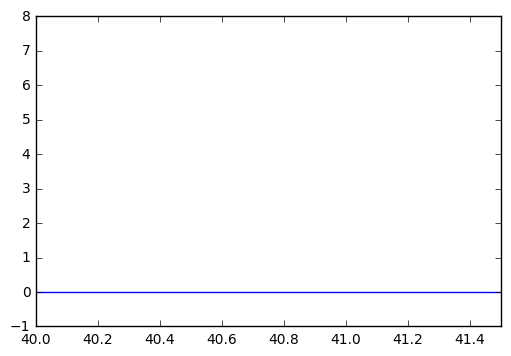

In [928]:
#plt.plot(ep_times,i1_spike_sig*-1 >2)
sig = (i1_spike_sig*-1 >2).astype(float)
plt.plot(scipy.signal.fftconvolve(i1_spike_sig*-1 >2,slow_kernel))
plt.gca().set_xbound(40,41.5)

In [ ]:
scipy.signal